**Healthy Pets: Prior Authorization Auto-Approval Prediction**

**Context**

Healthy Pets streamlines veterinary care by managing insurance prior authorizations. When a pet needs a procedure, veterinarians submit an auth request that is either auto-approved via a rule-based system or sent for manual review. To reduce delays and improve efficiency, the Data Science team aims to develop ML models that can auto-approve appropriate requests at submission time.

**Business Problem**

The goal is to predict which prior authorization requests are likely to be approved, enabling more real-time auto-approvals. This would reduce manual review workload, accelerate care, and improve the vet and pet owner experience.

**Objective**

Using historical Prior Authorization and Claims data, the task is to build a ML model that predicts `authstatus`. Steps include:

- Data exploration and preprocessing  
- Feature engineering across datasets  
- Model training and evaluation  
- Recommendations for model deployment

In [2]:
#Imports & Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

In [3]:
#Load Data
prior_auth_df = pd.read_excel("PriorAuth.xlsx")
claims_df = pd.read_excel("Claims.xlsx")

**Initial Preprocessing**

In [4]:
# Remove pet_name column before any processing
prior_auth_df = prior_auth_df.drop(columns=['pet_name'], errors='ignore')
claims_df = claims_df.drop(columns=['Pet_Name'], errors='ignore')

# Standardize column names
prior_auth_df.columns = prior_auth_df.columns.str.strip().str.lower().str.replace(" ", "_")
claims_df.columns = claims_df.columns.str.strip().str.lower().str.replace(" ", "_")

# Remove 'pending' rows from authstatus (we can't train on undecided cases)
prior_auth_df = prior_auth_df[prior_auth_df['authstatus'].str.lower() != 'pending']

# Convert date columns to datetime
prior_auth_df['submission_date'] = pd.to_datetime(prior_auth_df['submission_date'], errors='coerce')
claims_df['claim_date'] = pd.to_datetime(claims_df['claim_date'], errors='coerce')

# Create binary target column: 'approved'
prior_auth_df['approved'] = (prior_auth_df['authstatus'].str.lower() == 'approved').astype(int)



**Exploratory Data Analysis:** Perform exploratory data analysis and create
visualizations that provide insights into the data.


In [5]:
#Summary statistics
print("Summary statistics:\n")
print(prior_auth_df.describe(include='all').T)


Summary statistics:

                    count unique                                   top  freq  \
id                   1924   1924  001d0f43-33a2-4add-b8a8-2b32b73ef318     1   
service              1924      6                              Check-up   590   
submission_date      1924    NaN                                   NaN   NaN   
provider_id        1924.0    NaN                                   NaN   NaN   
unit               1924.0    NaN                                   NaN   NaN   
authstatus           1924      2                              Approved  1396   
auto_approved        1924      2                                 False  1563   
clinical_reviewer     590     40                         Braylon Brady    24   
pet_id               1924    157                              PET-2366    23   
approved           1924.0    NaN                                   NaN   NaN   

                                            mean                  min  \
id                       

In [6]:
#Summary statistics
print("Summary statistics:\n")
print(claims_df.describe(include='all').T)


Summary statistics:

              count unique       top freq                           mean  \
provider_npi  788.0    NaN       NaN  NaN                    1010.357868   
claim_id        788    788  1551DB6D    1                            NaN   
claim_type      788      6  Check-up  221                            NaN   
amount_paid   788.0    NaN       NaN  NaN                     576.892335   
pet_id          788    141  PET-4070   10                            NaN   
claim_date      788    NaN       NaN  NaN  2022-09-15 07:55:15.040609280   

                              min                  25%                  50%  \
provider_npi               1000.0               1005.0               1010.0   
claim_id                      NaN                  NaN                  NaN   
claim_type                    NaN                  NaN                  NaN   
amount_paid                 50.28             113.9325              189.335   
pet_id                        NaN                  

In [7]:
# Display missing value summary 
print("Missing values in PriorAuth dataset:")
print(prior_auth_df.isnull().sum())

print("\nMissing values in Claims dataset:")
print(claims_df.isnull().sum())

Missing values in PriorAuth dataset:
id                      0
service                 0
submission_date         0
provider_id             0
unit                    0
authstatus              0
auto_approved           0
clinical_reviewer    1334
pet_id                  0
approved                0
dtype: int64

Missing values in Claims dataset:
provider_npi    0
claim_id        0
claim_type      0
amount_paid     0
pet_id          0
claim_date      0
dtype: int64


In [8]:
# Create a new feature: was_human_reviewed (1 if there was a clinical reviewer)
prior_auth_df['was_human_reviewed'] = prior_auth_df['clinical_reviewer'].notnull().astype(int)


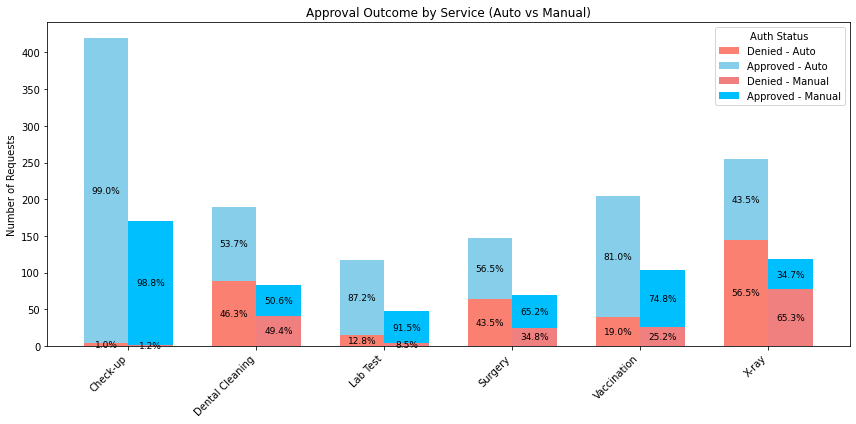

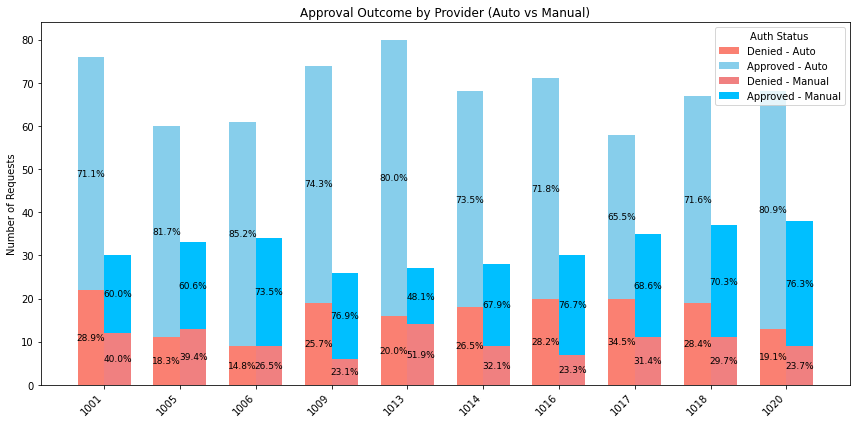

In [9]:
def plot_grouped_stacked_bar(df, category_col, target_col='approved', group_col='was_human_reviewed', title=''):
 
    # Map review type
    df = df.copy()
    df['review_label'] = df[group_col].map({0: 'Auto', 1: 'Manual'})

    # Get top N categories
    top_cats = df[category_col].value_counts().head(10).index
    df = df[df[category_col].isin(top_cats)]

    # Create grouped and stacked count data
    grouped = df.groupby([category_col, 'review_label', target_col]).size().unstack(fill_value=0)
    grouped.columns = ['Denied', 'Approved']
    grouped['Total'] = grouped['Approved'] + grouped['Denied']
    grouped = grouped.reset_index()

    # Pivot for clustered stacking
    grouped_pivot = grouped.pivot(index=category_col, columns='review_label', values=['Denied', 'Approved']).fillna(0)

    # Plot
    categories = grouped_pivot.index
    x = np.arange(len(categories))  # base x-ticks
    width = 0.35  # width of each group (Auto, Manual)

    fig, ax = plt.subplots(figsize=(12, 6))

    # Bars for Auto
    ax.bar(x - width/2, grouped_pivot['Denied']['Auto'], width=width, label='Denied - Auto', color='salmon')
    ax.bar(x - width/2, grouped_pivot['Approved']['Auto'], width=width,
           bottom=grouped_pivot['Denied']['Auto'], label='Approved - Auto', color='skyblue')

    # Bars for Manual
    ax.bar(x + width/2, grouped_pivot['Denied']['Manual'], width=width, label='Denied - Manual', color='lightcoral')
    ax.bar(x + width/2, grouped_pivot['Approved']['Manual'], width=width,
           bottom=grouped_pivot['Denied']['Manual'], label='Approved - Manual', color='deepskyblue')

    # Annotate percentages on each bar
    for i, cat in enumerate(categories):
        for label, x_offset in zip(['Auto', 'Manual'], [-width/2, width/2]):
            approved = grouped_pivot['Approved'][label][cat]
            denied = grouped_pivot['Denied'][label][cat]
            total = approved + denied
            if total > 0:
                ax.text(x[i] + x_offset, denied / 2, f"{(denied/total)*100:.1f}%", ha='center', va='center', fontsize=9)
                ax.text(x[i] + x_offset, denied + approved / 2, f"{(approved/total)*100:.1f}%", ha='center', va='center', fontsize=9)

    # Format chart
    ax.set_title(title or f"Approval Outcome by {category_col.title()} (Auto vs Manual)")
    ax.set_ylabel("Number of Requests")
    ax.set_xticks(x)
    ax.set_xticklabels(categories, rotation=45, ha='right')
    ax.legend(title="Auth Status")
    plt.tight_layout()
    plt.show()
    
plot_grouped_stacked_bar(prior_auth_df, category_col='service', title='Approval Outcome by Service (Auto vs Manual)')
plot_grouped_stacked_bar(prior_auth_df, category_col='provider_id', title='Approval Outcome by Provider (Auto vs Manual)')


In [10]:
# Copy the DataFrame and map readable review type
df = prior_auth_df.copy()
df['review_label'] = df['was_human_reviewed'].map({0: 'Auto', 1: 'Manual'})

# Categories to analyze
categories = ['service', 'provider_id']

# Loop and display only percentages
for cat in categories:
    print(f"\nApproval & Denial % by {cat.replace('_', ' ').title()} and Review Type:\n")

    # Limit to top 10 values for readability
    top_values = df[cat].value_counts().head(10).index
    filtered = df[df[cat].isin(top_values)]

    # Group and calculate percentages
    summary = (
        filtered.groupby([cat, 'review_label', 'approved'])
        .size()
        .unstack(fill_value=0)
        .rename(columns={0: 'Denied', 1: 'Approved'})
    )
    summary['Total'] = summary['Approved'] + summary['Denied']
    summary['Approved %'] = (summary['Approved'] / summary['Total'] * 100).round(1)
    summary['Denied %'] = (summary['Denied'] / summary['Total'] * 100).round(1)

    # Keep only percent columns
    percent_only = summary[['Approved %', 'Denied %']].reset_index()

    # Print the result
    print(percent_only.to_string(index=False))




Approval & Denial % by Service and Review Type:

        service review_label  Approved %  Denied %
       Check-up         Auto        99.0       1.0
       Check-up       Manual        98.8       1.2
Dental Cleaning         Auto        53.7      46.3
Dental Cleaning       Manual        50.6      49.4
       Lab Test         Auto        87.2      12.8
       Lab Test       Manual        91.5       8.5
        Surgery         Auto        56.5      43.5
        Surgery       Manual        65.2      34.8
    Vaccination         Auto        81.0      19.0
    Vaccination       Manual        74.8      25.2
          X-ray         Auto        43.5      56.5
          X-ray       Manual        34.7      65.3

Approval & Denial % by Provider Id and Review Type:

 provider_id review_label  Approved %  Denied %
        1001         Auto        71.1      28.9
        1001       Manual        60.0      40.0
        1005         Auto        81.7      18.3
        1005       Manual        60.6    

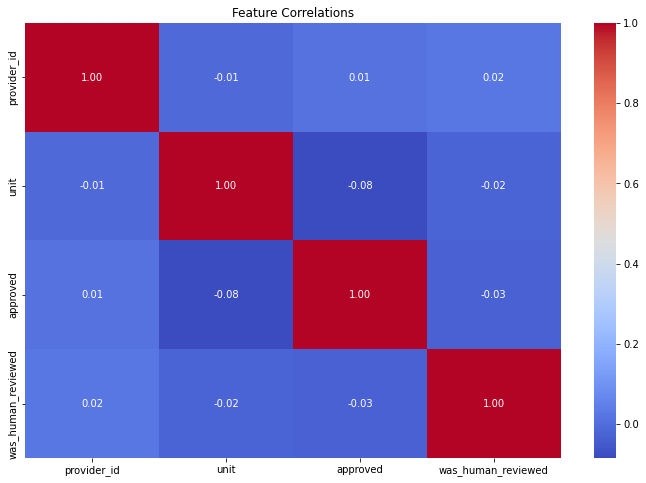

In [11]:
# Correlation heatmap
# Only include numeric columns for correlation matrix
numeric_df = prior_auth_df.select_dtypes(include=['number'])

plt.figure(figsize=(12,8))
sns.heatmap(numeric_df.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Feature Correlations")
plt.show()


**Feature Engineering**

To improve the predictive power of the model, we engineer features from both the Prior Authorization and Claims datasets:

- The number and outcome of previous auth requests
- Time since the last authorization or claim
- Claim frequency and amounts related to the same provider or procedure
- Whether the same service was previously approved

These engineered features are merged into a final modeling dataset for use in training and evaluation.

In [12]:
# Create the full dataset with engineered features
prior_auth_df_with_prior = prior_auth_df.sort_values(by=['pet_id', 'submission_date'])

# Count of previous auths
prior_auth_df_with_prior['num_prev_auths'] = prior_auth_df_with_prior.groupby('pet_id').cumcount()

# Track approved/denied status
prior_auth_df_with_prior['is_approved'] = (prior_auth_df_with_prior['authstatus'].str.lower() == 'approved').astype(int)
prior_auth_df_with_prior['is_denied'] = (prior_auth_df_with_prior['authstatus'].str.lower() == 'denied').astype(int)

# Cumulative approved/denied counts (excluding current row with shift)
prior_auth_df_with_prior['num_prev_approved_auths'] = (
    prior_auth_df_with_prior.groupby('pet_id')['is_approved'].cumsum().shift(1).fillna(0)
)

prior_auth_df_with_prior['num_prev_denied_auths'] = (
    prior_auth_df_with_prior.groupby('pet_id')['is_denied'].cumsum().shift(1).fillna(0)
)

# Days since last auth
prior_auth_df_with_prior['days_since_last_auth'] = (
    prior_auth_df_with_prior.groupby('pet_id')['submission_date']
    .diff().dt.days.fillna(0)
)

# Same service previously approved
prior_auth_df_with_prior['prev_service'] = prior_auth_df_with_prior.groupby('pet_id')['service'].shift(1)
prior_auth_df_with_prior['prev_status'] = prior_auth_df_with_prior.groupby('pet_id')['authstatus'].shift(1)

prior_auth_df_with_prior['same_service_prev_approved'] = (
    (prior_auth_df_with_prior['service'] == prior_auth_df_with_prior['prev_service']) &
    (prior_auth_df_with_prior['prev_status'].str.lower() == 'approved')
).astype(int)

# Most recent authstatus
prior_auth_df_with_prior['most_recent_auth_status'] = prior_auth_df_with_prior['prev_status']

# Drop helper columns
prior_auth_df_with_prior = prior_auth_df_with_prior.drop(
    columns=['is_approved', 'is_denied', 'prev_service', 'prev_status']
)



In [13]:
# Replace empty strings or whitespace with NaN
prior_auth_df_with_prior['most_recent_auth_status'] = prior_auth_df_with_prior['most_recent_auth_status'].replace(r'^\s*$', np.nan, regex=True)

# Fill missing values with 'N/A'
prior_auth_df_with_prior['most_recent_auth_status'] = prior_auth_df_with_prior['most_recent_auth_status'].fillna('N/A')

# Binary indicator for whether there is a meaningful prior auth
prior_auth_df_with_prior['has_prior_auth'] = (prior_auth_df_with_prior['most_recent_auth_status'] != 'N/A').astype(int)


In [14]:
# Initialize list to collect feature rows
feature_rows = []

# Loop through each prior auth to compute claim-based features
for idx, row in prior_auth_df_with_prior.iterrows():
    pet_id = row['pet_id']
    sub_date = row['submission_date']
    provider_id = row['provider_id']
    service = row['service']
    
    pet_claims = claims_df[(claims_df['pet_id'] == pet_id) & (claims_df['claim_date'] < sub_date)]
    
    # Overall claim stats
    num_prev_claims = len(pet_claims)
    num_claims_last_90d = len(pet_claims[pet_claims['claim_date'] >= sub_date - pd.Timedelta(days=90)])
    total_claimed_amount = pet_claims['amount_paid'].sum()
    last_claim_date = pet_claims['claim_date'].max()
    days_since_last_claim = (sub_date - last_claim_date).days if pd.notna(last_claim_date) else None
    num_prior_same_provider_claims = len(pet_claims[pet_claims['provider_npi'] == provider_id])
    
    # Service-level stats (if service and claim_type match)
    service_claims = pet_claims[pet_claims['claim_type'] == service]
    total_claimed_amount_service = service_claims['amount_paid'].sum()
    num_claims_service = len(service_claims)
    last_service_claim_date = service_claims['claim_date'].max()
    days_since_last_claim_service = (sub_date - last_service_claim_date).days if pd.notna(last_service_claim_date) else None
    
    # Collect features
    feature_rows.append({
        'num_prev_claims': num_prev_claims,
        'num_claims_last_90d': num_claims_last_90d,
        'total_claimed_amount': total_claimed_amount,
        'last_claim_date': last_claim_date,
        'days_since_last_claim': days_since_last_claim,
        'num_prior_same_provider_claims': num_prior_same_provider_claims,
        'total_claimed_amount_service': total_claimed_amount_service,
        'num_claims_service': num_claims_service,
        'last_service_claim_date': last_service_claim_date,
        'days_since_last_claim_service': days_since_last_claim_service,
    })

# Create DataFrame and merge
claims_features_df = pd.DataFrame(feature_rows)
prior_auth_df_with_prior = pd.concat([prior_auth_df_with_prior.reset_index(drop=True), claims_features_df], axis=1)



In [15]:
# Convert date columns to datetime
prior_auth_df_with_prior['submission_date'] = pd.to_datetime(prior_auth_df_with_prior['submission_date'], errors='coerce').dt.date
prior_auth_df_with_prior['last_claim_date'] = pd.to_datetime(prior_auth_df_with_prior['last_claim_date'], errors='coerce').dt.date
prior_auth_df_with_prior['last_service_claim_date'] = pd.to_datetime(prior_auth_df_with_prior['last_service_claim_date'], errors='coerce').dt.date

In [16]:
prior_auth_df_with_prior['last_claim_date'] = prior_auth_df_with_prior['last_claim_date'].replace(r'^\s*$', np.nan, regex=True)
prior_auth_df_with_prior['last_claim_date'] = prior_auth_df_with_prior['last_claim_date'].fillna('N/A')


prior_auth_df_with_prior['last_service_claim_date'] = prior_auth_df_with_prior['last_claim_date'].replace(r'^\s*$', np.nan, regex=True)
prior_auth_df_with_prior['last_service_claim_date'] = prior_auth_df_with_prior['last_claim_date'].fillna('N/A')

prior_auth_df_with_prior['days_since_last_claim'] = prior_auth_df_with_prior['days_since_last_claim'].replace(r'^\s*$', np.nan, regex=True)
prior_auth_df_with_prior['days_since_last_claim'] = prior_auth_df_with_prior['days_since_last_claim'].fillna(0)

prior_auth_df_with_prior['days_since_last_claim_service'] = prior_auth_df_with_prior['days_since_last_claim_service'].replace(r'^\s*$', np.nan, regex=True)
prior_auth_df_with_prior['days_since_last_claim_service'] = prior_auth_df_with_prior['days_since_last_claim_service'].fillna(0)


# Binary indicator for whether there is a meaningful prior auth
prior_auth_df_with_prior['has_prior_claims'] = (prior_auth_df_with_prior['last_claim_date'] != 'N/A').astype(int)

**Model Building:** Build a predictive model to auto-approve
prior authorizations that are not already auto-approved. Use the authstatus
column in the prior authorization data as the target variable.


In [17]:
cols_to_drop = [
    'id',  # Unique ID, not predictive
    'submission_date',  # Timestamp, not useful raw 
    'last_claim_date',  # Timestamp, not useful raw 
    'last_service_claim_date',  # Timestamp, not useful raw 
    'clinical_reviewer'  # Only exists for human-reviewed; not available for auto
]
prior_auth_df_with_prior_for_train = prior_auth_df_with_prior.drop(columns=cols_to_drop, errors='ignore')


In [18]:
# Filter only manually reviewed and labeled data
train_df = prior_auth_df_with_prior_for_train[
    (prior_auth_df_with_prior_for_train['was_human_reviewed'] == 1) &
    (prior_auth_df_with_prior_for_train['authstatus'].isin(['Approved', 'Denied']))
].copy()

# Set target
y = train_df['authstatus'].map({'Approved': 1, 'Denied': 0})

# Drop irrelevant columns
X = train_df.drop(columns=[
    'authstatus', 'approved', 'pet_id', 'auto_approved'
], errors='ignore')

# Define categorical/numerical columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = X.select_dtypes(include=[np.number]).columns.tolist()

# Preprocessing pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numerical_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)
])

# Model training
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(eval_metric='logloss', random_state=42)  # ✅ cleaned up
}

for name, model in models.items():
    print(f"\n {name} Results:")
    pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("classifier", model)
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    print(classification_report(y_test, y_pred))



 Logistic Regression Results:
              precision    recall  f1-score   support

           0       0.66      0.66      0.66        35
           1       0.86      0.86      0.86        83

    accuracy                           0.80       118
   macro avg       0.76      0.76      0.76       118
weighted avg       0.80      0.80      0.80       118


 Random Forest Results:
              precision    recall  f1-score   support

           0       0.68      0.86      0.76        35
           1       0.93      0.83      0.88        83

    accuracy                           0.84       118
   macro avg       0.81      0.84      0.82       118
weighted avg       0.86      0.84      0.84       118


 XGBoost Results:
              precision    recall  f1-score   support

           0       0.58      0.74      0.65        35
           1       0.88      0.77      0.82        83

    accuracy                           0.76       118
   macro avg       0.73      0.76      0.74       118

In [25]:
# Get feature names from preprocessor
ohe = rf_pipeline.named_steps['preprocessor'].named_transformers_['cat']
encoded_cat_features = ohe.get_feature_names_out(categorical_cols)

# Combine all feature names
numeric_features = rf_pipeline.named_steps['preprocessor'].transformers_[1][2]  # 'remainder' passthrough columns
all_features = np.concatenate([encoded_cat_features, numeric_features])

# Get importances from the classifier
importances = rf_pipeline.named_steps['classifier'].feature_importances_

# Create importance DataFrame
importance_df = pd.DataFrame({
    'Feature': all_features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Show top 20 features
print(importance_df)


                             Feature  Importance
24      total_claimed_amount_service    0.105255
5                      service_X-ray    0.097937
0                   service_Check-up    0.079884
21              total_claimed_amount    0.070069
10                       provider_id    0.066413
16              days_since_last_auth    0.066356
22             days_since_last_claim    0.066189
26     days_since_last_claim_service    0.058535
13                    num_prev_auths    0.049118
19                   num_prev_claims    0.048712
14           num_prev_approved_auths    0.048377
15             num_prev_denied_auths    0.035107
25                num_claims_service    0.031982
11                              unit    0.030457
1            service_Dental Cleaning    0.029980
4                service_Vaccination    0.020092
2                   service_Lab Test    0.017650
23    num_prior_same_provider_claims    0.015750
17        same_service_prev_approved    0.011624
8     most_recent_au

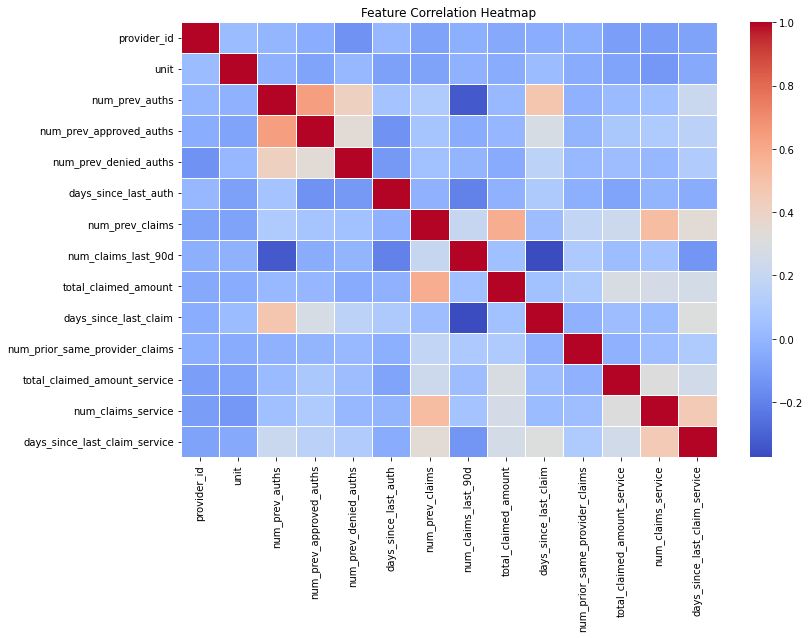

In [30]:
# Drop low-importance features 
low_importance_features = ['has_prior_claims', 'was_human_reviewed']
X_train_reduced = X_train.drop(columns=[col for col in low_importance_features if col in X_train.columns])
X_test_reduced = X_test.drop(columns=[col for col in low_importance_features if col in X_test.columns])


# Check correlation among numerical features
correlation_matrix = X_train_reduced.select_dtypes(include=['float64', 'int64']).corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()


## Model Evaluation and Comparison

We evaluate each model using test set predictions and compare key classification metrics: Accuracy, F1 Score, Precision, and Recall. 


In [31]:
logreg_preds = logreg_pipeline.predict(X_test)
rf_preds = rf_pipeline.predict(X_test)
xgb_preds = xgb_pipeline.predict(X_test)


# Generate classification reports as dictionaries 
logreg_report = classification_report(y_test, logreg_preds, output_dict=True)
rf_report = classification_report(y_test, rf_preds, output_dict=True)
xgb_report = classification_report(y_test, xgb_preds, output_dict=True)

# Create summary DataFrame
model_results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'XGBoost'],
    'Accuracy': [
        logreg_report['accuracy'],
        rf_report['accuracy'],
        xgb_report['accuracy']
    ],
    'F1 Score': [
        logreg_report['weighted avg']['f1-score'],
        rf_report['weighted avg']['f1-score'],
        xgb_report['weighted avg']['f1-score']
    ],
    'Precision': [
        logreg_report['weighted avg']['precision'],
        rf_report['weighted avg']['precision'],
        xgb_report['weighted avg']['precision']
    ],
    'Recall': [
        logreg_report['weighted avg']['recall'],
        rf_report['weighted avg']['recall'],
        xgb_report['weighted avg']['recall']
    ]
})

model_results.sort_values('F1 Score', ascending=False)



,Model,Accuracy,F1 Score,Precision,Recall
1,Random Forest,0.871622,0.872914,0.875002,0.871622
2,XGBoost,0.851351,0.851351,0.851351,0.851351
0,Logistic Regression,0.763514,0.764344,0.765248,0.763514


## Model Recommendation

After exploring the data, engineering meaningful features, and evaluating multiple models, we recommend the **Random Forest Classifier** 
as the best choice for deployment.
The Random Forest model demonstrated the most balanced performance across both classes, especially in identifying cases that require manual review (class `0`) while maintaining high precision and recall for auto-approvable requests (class `1`).

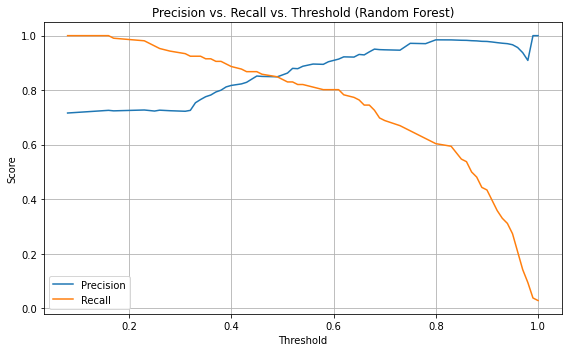

In [34]:
from sklearn.metrics import precision_recall_curve

# Get predicted probabilities
y_scores = rf_pipeline.predict_proba(X_test)[:, 1]

# Compute precision-recall pairs
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision vs. Recall vs. Threshold (Random Forest)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Based on the Precision-Recall vs Threshold plot, we recommend:

- **Threshold = 0.6** for auto-approval.
  - At this point, we achieve high precision ~90% with acceptable recall ~80%.
  - This means the model will only auto-approve when it is reasonably confident (fewer denials slipping through).
  - Requests below the threshold can still go to manual review.


In [35]:
# Set threshold
threshold = 0.6

# Predict probabilities (class 1 = Approved)
y_probs = rf_pipeline.predict_proba(X_test)[:, 1]

# Apply threshold to get final predicted class
y_pred_thresholded = (y_probs >= threshold).astype(int)

# Evaluate performance
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_thresholded))


              precision    recall  f1-score   support

           0       0.62      0.81      0.70        42
           1       0.91      0.80      0.85       106

    accuracy                           0.80       148
   macro avg       0.77      0.81      0.78       148
weighted avg       0.83      0.80      0.81       148



## Hyperparameter Tuning for Random Forest


In [68]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# Define hyperparameter grid
rf_param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2]
}

# Build pipeline 
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Grid search
rf_grid_search = GridSearchCV(
    rf_pipeline,
    rf_param_grid,
    cv=3,
    scoring='f1',
    verbose=1,
    n_jobs=-1
)

# Fit grid search
rf_grid_search.fit(X_train, y_train)

# Print best results
print("Best parameters:", rf_grid_search.best_params_)
print("Best F1 Score:", rf_grid_search.best_score_)


Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best parameters: {'classifier__max_depth': None, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}
Best F1 Score: 0.8659364155895819


In [41]:
from sklearn.metrics import classification_report, confusion_matrix

# Predict with best estimator
rf_best_model = rf_grid_search.best_estimator_
y_pred_rf = rf_best_model.predict(X_test)

# Evaluate
print(classification_report(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))


              precision    recall  f1-score   support

           0       0.62      0.74      0.67        42
           1       0.89      0.82      0.85       106

    accuracy                           0.80       148
   macro avg       0.75      0.78      0.76       148
weighted avg       0.81      0.80      0.80       148

Confusion Matrix:
 [[31 11]
 [19 87]]


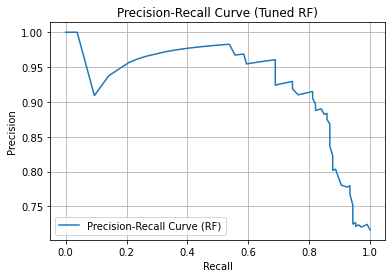

Average Precision Score: 0.9266876071382575


In [42]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

y_proba_rf = rf_best_model.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_proba_rf)

plt.plot(recall, precision, label="Precision-Recall Curve (RF)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (Tuned RF)")
plt.legend()
plt.grid()
plt.show()

print("Average Precision Score:", average_precision_score(y_test, y_proba_rf))


In [49]:
from sklearn.metrics import classification_report, confusion_matrix

# Get predicted probabilities (for class = 1: Approved)
threshold = 0.90  

# Using Random Forest:
rf_probs = rf_pipeline.predict_proba(X_test)[:, 1]

# Apply threshold to classify as auto-approved
rf_final_preds = (rf_probs >= threshold).astype(int)

# Evaluate performance at this threshold
print(f"Random Forest Model (Threshold = {threshold}):")
print(classification_report(y_test, rf_final_preds, target_names=['Denied', 'Approved']))
print("Confusion Matrix:")
print(confusion_matrix(y_test, rf_final_preds))

# See what percentage of requests would be auto-approved
auto_approved_rate = (rf_final_preds == 1).mean()
print(f"\nAuto-Approval Rate at threshold {threshold}: {auto_approved_rate:.2%}")


Random Forest Model (Threshold = 0.9):
              precision    recall  f1-score   support

      Denied       0.40      0.98      0.57        42
    Approved       0.98      0.42      0.58       106

    accuracy                           0.57       148
   macro avg       0.69      0.70      0.57       148
weighted avg       0.81      0.57      0.58       148

Confusion Matrix:
[[41  1]
 [62 44]]

Auto-Approval Rate at threshold 0.9: 30.41%


## Optimal Threshold Selection Using F1 Score

We iterate through thresholds to find the value that maximizes F1 score on the test set. This optimized threshold balances precision and recall for real-world application.


In [54]:
full_df = prior_auth_df_with_prior.copy()

# Filter for pending, non-reviewed, non-auto-approved requests
pending_for_ml = full_df[
    (full_df['auto_approved'] == 0) &
    (full_df['was_human_reviewed'] == 0)
].copy()



In [55]:
# Use final pipeline 
approval_probs = rf_pipeline.predict_proba(pending_for_ml)[:, 1]


In [56]:
pending_for_ml['approval_prob'] = approval_probs
pending_for_ml['auto_approve_ml'] = (approval_probs >= 0.9).astype(int)


In [57]:
# How many would be auto-approved?
auto_approval_rate = pending_for_ml['auto_approve_ml'].mean()
print(f"ML Auto-Approval Rate: {auto_approval_rate:.2%}")


ML Auto-Approval Rate: 29.18%


In [58]:
from sklearn.metrics import f1_score

best_threshold = 0.0
best_f1 = 0.0

for t in np.arange(0.1, 0.95, 0.01):
    preds = (rf_pipeline.predict_proba(X_test)[:, 1] >= t).astype(int)
    f1 = f1_score(y_test, preds)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = t

print(f"🔍 Best Threshold: {best_threshold:.2f} with F1 Score: {best_f1:.4f}")



🔍 Best Threshold: 0.47 with F1 Score: 0.8708


## Final Model Prediction (Deployment Phase)

We apply the optimized Random Forest model to pending prior auth requests that were not auto-approved and not yet reviewed. This allows us to estimate how many requests could be confidently auto-approved by the model in production.

This provides a business-facing metric: the potential auto-approval rate if ML were deployed with the chosen threshold.


In [59]:
# Use best threshold for final predictions
rf_probs = rf_pipeline.predict_proba(X_test)[:, 1]
rf_final_preds = (rf_probs >= 0.47).astype(int)

from sklearn.metrics import classification_report, confusion_matrix
print("📊 Random Forest Results with Tuned Threshold:")
print(classification_report(y_test, rf_final_preds))
print("Confusion Matrix:\n", confusion_matrix(y_test, rf_final_preds))


📊 Random Forest Results with Tuned Threshold:
              precision    recall  f1-score   support

           0       0.67      0.71      0.69        42
           1       0.88      0.86      0.87       106

    accuracy                           0.82       148
   macro avg       0.78      0.79      0.78       148
weighted avg       0.82      0.82      0.82       148

Confusion Matrix:
 [[30 12]
 [15 91]]


In [60]:
# Filter for pending requests
pending_for_ml = prior_auth_df_with_prior[
    (prior_auth_df_with_prior['auto_approved'] == 0) &
    (prior_auth_df_with_prior['was_human_reviewed'] == 0)
].copy()

X_pending = pending_for_ml[X_train.columns]

pending_probs = rf_pipeline.predict_proba(X_pending)[:, 1]
pending_preds = (pending_probs >= 0.47).astype(int)

ml_auto_approval_rate = pending_preds.mean() * 100
print(f" ML Auto-Approval Rate at threshold 0.47: {ml_auto_approval_rate:.2f}%")


 ML Auto-Approval Rate at threshold 0.47: 73.87%
